In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning

pytorch_lightning.seed_everything(123)
sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")
plt.rcParams['figure.figsize'] = [20, 6]
plt.rcParams['axes.labelsize'] = 0

Seed set to 123


In [2]:
class MixedDensityNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, num_components, num_hidden=64):
        super().__init__()
        self.num_components = num_components
        self.output_dim = output_dim
        
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
        )
        self.mixture = nn.Linear(num_hidden, num_components)
        self.log_sigma = nn.Linear(num_hidden, num_components * output_dim)
        self.mu = nn.Linear(num_hidden, num_components * output_dim)
    
    def forward(self, x):
        out = self.hidden(x)
        mixture = torch.softmax(self.mixture(out), dim=1).unsqueeze(-1)
        sigma = torch.exp(self.log_sigma(out.detach())).view(-1, self.num_components, self.output_dim)
        mu = self.mu(out).view(-1, self.num_components, self.output_dim)
        return mixture, sigma, mu

    def compute_loss(self, targets, predictions, eps=1e-6):
        mixture, sigma, mu = predictions
        log_prob = torch.distributions.Normal(loc=mu, scale=sigma).log_prob(targets.unsqueeze(-1))
        log_mixture = torch.log(mixture + eps)
        log_likelihood = torch.logsumexp(log_mixture + log_prob, dim=1)
        return -torch.mean(log_likelihood)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def fit(self, x, y, epochs=1, verbose=1):
        optimizer = self.configure_optimizers()

        for epoch in range(epochs):
            self.train()
            optimizer.zero_grad()
            predictions = self(x)
            loss = self.compute_loss(y, predictions)
            loss.backward()
            optimizer.step()

            if verbose:
               print(f"{epoch:<4} {loss.item()}")

### Gabor model

In [3]:
n = 1000
x = torch.linspace(-2, 2, 2*n)
p, q, r = 0, 2, 4
y = torch.sin(p + r * q * x) * torch.exp(-(p + r * q * x)**2/32.0)
std = .1


ids = np.random.choice(torch.arange(len(x)), n)
X = x[ids]
Y = y[ids] + np.random.normal(0, std, n)

0    1.0314257698034117
1    1.0195421088546937
2    1.0082564414660782
3    0.9971337431289243
4    0.9860634951427221
5    0.974923067273838
6    0.9632564035297325
7    0.9507946021428892
8    0.9372080338881287
9    0.9224509910944271
10   0.9069429521263729
11   0.8907195492076393
12   0.873640674577155
13   0.8556850831467998
14   0.8368127102923736
15   0.8171129395902035
16   0.7965809336986281
17   0.7750410186878507
18   0.7524714185167652
19   0.7288555856633979
20   0.7041367804411168
21   0.678143889862909
22   0.6507741186582722
23   0.6220599868393968
24   0.5921468580725798
25   0.5612042132961811
26   0.5294647628119363
27   0.49708723679237676
28   0.46416953213034245
29   0.430531774775446
30   0.3963601437407678
31   0.3622259553539328
32   0.32827879416204225
33   0.2941571996851589
34   0.2597706182943764
35   0.22613391394805182
36   0.19309650022217842
37   0.16067393093877524
38   0.1309627752151651
39   0.10189726015749304
40   0.07588493584761646
41   0.05145

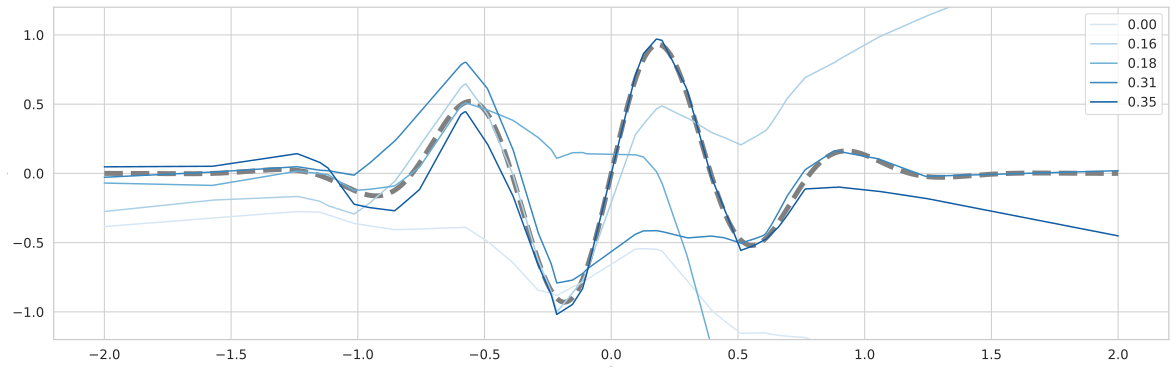

In [4]:
model = MixedDensityNetwork(input_dim=1, output_dim=1, num_components=5)
model.fit(X.unsqueeze(1), Y.unsqueeze(1), epochs=5000)

mixture, sigma, mu = model(x.unsqueeze(1))
contribution = mixture.detach().squeeze().mean(dim=0).numpy()
palette = sns.color_palette("Blues", n_colors=model.num_components)

plt.ylim(-1.2, 1.2)
sns.lineplot(x=x, y=y, linestyle="--", color="gray", linewidth=5)
for i, component in enumerate(sorted(range(model.num_components), key=lambda i: contribution[i])):
    sns.lineplot(x=x, y=mu.detach().squeeze().T[component], color=palette[i], label=f"{contribution[component]:.2f}")

<Axes: xlabel='None', ylabel='None'>

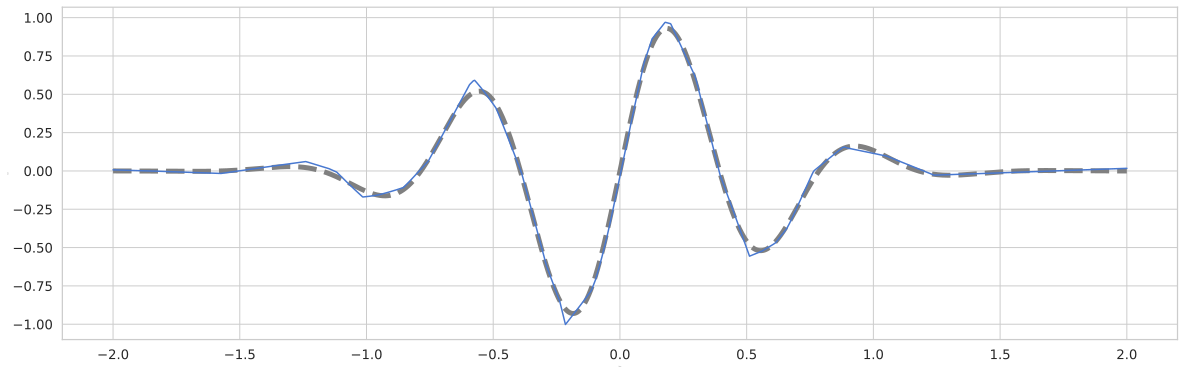

In [5]:
combined = torch.sum(mixture * mu, dim=1).detach().squeeze()
sns.lineplot(x=x, y=y, linestyle="--", color="gray", linewidth=5)
sns.lineplot(x=x, y=combined)

### Bimodal data distribution

<Axes: xlabel='None', ylabel='None'>

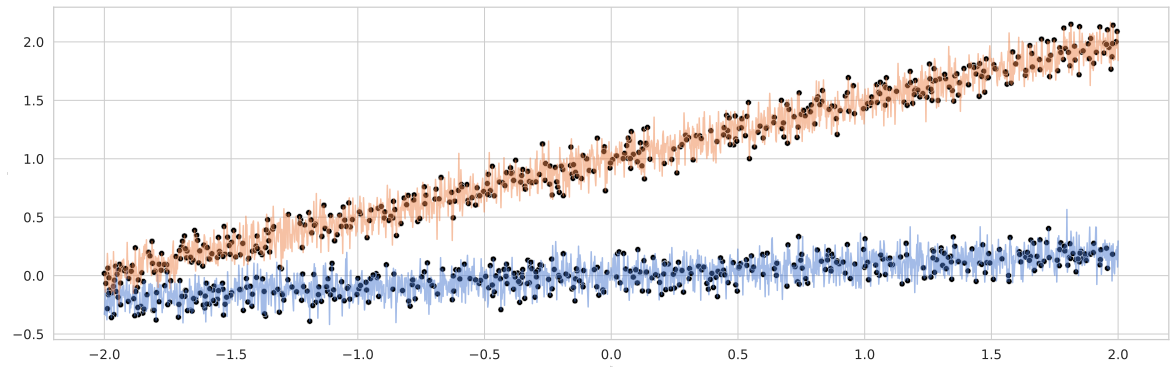

In [26]:
n = 1000
x = torch.linspace(-2, 2, 2*n)
def linenoise(x, a, b, std = .1):
	return a*x + b + np.random.normal(0, std, len(x))

line1 = linenoise(x, 0.1, 0)
line2 = linenoise(x, 0.5, 1)

sns.lineplot(x=x, y=line1, alpha=0.5)
sns.lineplot(x=x, y=line2, alpha=0.5)

ids = np.random.choice(torch.arange(2*len(x)), n)
X = torch.concatenate([x, x])[ids]
Y = torch.concatenate([line1, line2])[ids]
sns.scatterplot(x=X, y=Y, color="black")

In [27]:
model = MixedDensityNetwork(input_dim=1, output_dim=1, num_components=2)
model.fit(X.unsqueeze(1), Y.unsqueeze(1), epochs=5000)

0    1.2380094945513824
1    1.1980219220852482
2    1.16131428719825
3    1.127993415516812
4    1.0979930214624993
5    1.0711109254111892
6    1.0469980471935705
7    1.0250681262893564
8    1.0053765012640072
9    0.9879917263625954
10   0.9723162292662452
11   0.957839663154297
12   0.9443857055987879
13   0.9317832239253772
14   0.9201682195499573
15   0.9091232992861037
16   0.8987459998253409
17   0.8889424556358866
18   0.8799699477240587
19   0.8719880523235274
20   0.8649916588654717
21   0.8589956008978038
22   0.8539502572572811
23   0.8497163659753006
24   0.8461885723983794
25   0.8432026596672304
26   0.8404649000434596
27   0.8376675784583762
28   0.834525700225585
29   0.8308591439089608
30   0.8266199309463402
31   0.8217635723807258
32   0.8163070503151628
33   0.8103377995135568
34   0.8039742657825429
35   0.7973910828134865
36   0.7907592972858406
37   0.7841552906671773
38   0.7776624045213614
39   0.7713248095620218
40   0.7651738440448068
41   0.75920472457736

<Axes: xlabel='None', ylabel='None'>

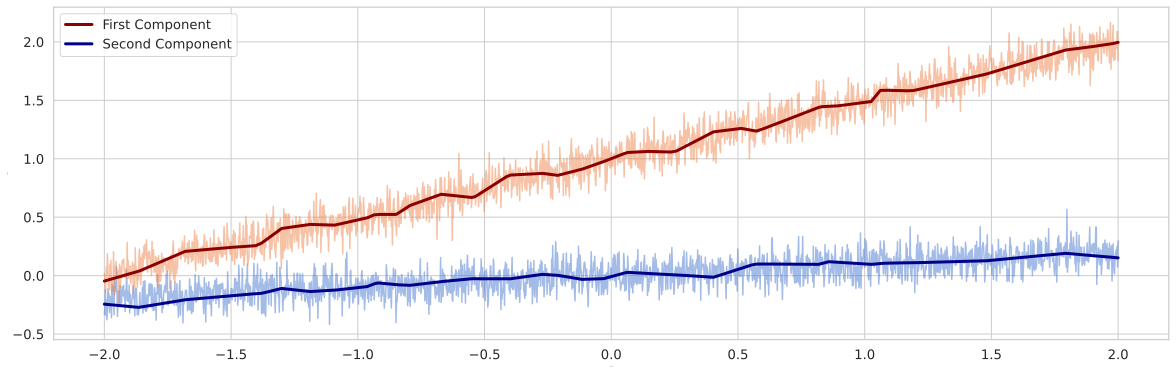

In [44]:
mixture, sigma, mu = model(x.unsqueeze(1))
contribution = mixture.detach().squeeze().mean(dim=0).numpy()
palette = sns.color_palette("Blues", n_colors=model.num_components)


mixture, sigma, mu = model(x.unsqueeze(1))

sns.lineplot(x=x, y=line1, alpha=0.5)
sns.lineplot(x=x, y=line2, alpha=0.5)
sns.lineplot(x=x, y=mu.detach().squeeze().T[0], color="darkred", linewidth=3, label="First Component")
sns.lineplot(x=x, y=mu.detach().squeeze().T[1], color="darkblue", linewidth=3, label="Second Component")